In [1]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import torch
import time
import traceback
from diffusers import DiffusionPipeline
from diffusers import EulerAncestralDiscreteScheduler

In [2]:
torch.cuda.get_device_name(torch.cuda.current_device()), torch.version.cuda, torch.backends.cudnn.version()

('Tesla V100-SXM2-16GB', '11.8', 8700)

In [3]:
# torch.nn.functional.scaled_dot_product_attention

<function torch._C._nn.scaled_dot_product_attention>

In [4]:
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",    
    torch_dtype=torch.float16,
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

In [5]:
pipe.enable_xformers_memory_efficient_attention()

In [6]:
batch_size_list = [2 ** x for x in range(0, 8)]
steps = 50
cfg_scale = 15
prompt = "postapocalyptic steampunk city, exploration, cinematic, realistic, hyper detailed, photorealistic maximum detail, volumetric light, (((focus))), wide-angle, (((brightly lit))), (((vegetation))), lightning, vines, destruction, devastation, wartorn, ruins"
# prompt = "detailed portrait beautiful Neon Operator Girl, cyberpunk futuristic neon, reflective puffy coat, decorated with traditional Japanese ornaments by Ismail inceoglu dragan bibin hans thoma greg rutkowski Alexandros Pyromallis Nekro Rene Maritte Illustrated, Perfect face, fine details, realistic shaded, fine-face, pretty face"
negative_prompt = "(((blurry))), ((foggy)), (((dark))), ((monochrome)), sun, (((depth of field)))"

In [7]:
pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)
pipe.vae = torch.compile(pipe.vae, mode="reduce-overhead", fullgraph=True)
pipe.text_encoder = torch.compile(pipe.text_encoder, mode="reduce-overhead", fullgraph=True)

In [ ]:
# prewarm
batch_size = 4
t0 = time.time()
_ = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    num_images_per_prompt=batch_size,
    guidance_scale=cfg_scale,
    height=512,
    width=512,
    ).images
t1 = time.time()
its = steps * batch_size / (t1 - t0)
print("batch_size {}, it/s: {}, time: {}".format(batch_size, round(its, 2), round((t1 - t0), 2)))

In [8]:
batch_size_list = [1, 1, 2, 2, 4, 4, 8, 8, 16, 16, 32, 32, 64, 64, 128, 128]

In [9]:
result = []
for batch_size in batch_size_list:
    try:
        t0 = time.time()
        images = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=steps,
            num_images_per_prompt=batch_size,
            guidance_scale=cfg_scale,
            height=512,
            width=512,
            ).images
        t1 = time.time()
        its = steps * batch_size / (t1 - t0)
        print("batch_size {}, it/s: {}, time: {}".format(batch_size, round(its, 2), round((t1 - t0), 2)))
    except torch.cuda.OutOfMemoryError as e:
        print("batch_size {}, OOM".format(batch_size))
        its = 0
    except Exception:
        print(traceback.print_exc())
    result.append(round(its, 2))
result_jit = result[1::2]

  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 1, it/s: 0.47, time: 107.45


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 1, it/s: 18.4, time: 2.72


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 2, it/s: 1.28, time: 78.4


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 2, it/s: 22.5, time: 4.44


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 4, it/s: 2.83, time: 70.66


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 4, it/s: 25.85, time: 7.74


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 8, it/s: 5.52, time: 72.41


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 8, it/s: 27.4, time: 14.6


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 16, OOM


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 16, OOM


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 32, OOM


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 32, OOM


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 64, OOM


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 64, OOM


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 128, OOM


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 128, OOM


In [10]:
result_jit

[18.4, 22.5, 25.85, 27.4, 0, 0, 0, 0]

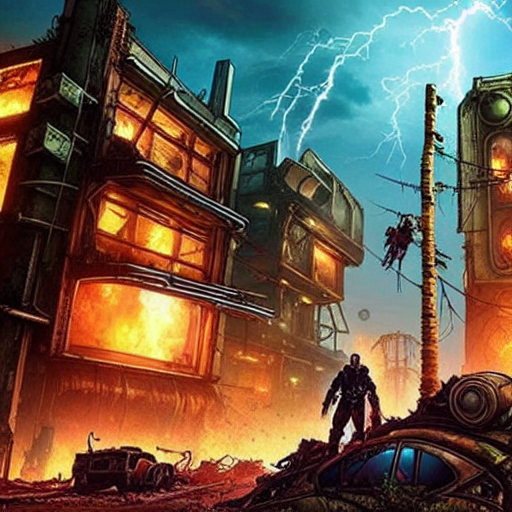

In [11]:
images[0]